# Data Cleaning and Preprocessing for Modeling

In [57]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
import re
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas_profiling
from pandas_profiling import ProfileReport

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans

# adaboost imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
# import cross_val_score
from sklearn.model_selection import cross_val_score

from math import floor
from sklearn.preprocessing import StandardScaler

# LogisticRegression
from sklearn.linear_model import LogisticRegression

# Tree imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import export_text

from tqdm import tqdm
# from alive_progress import alive_bar

# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Functions

In [58]:
def censor_words(text):
    # Remove all words that begin with 'aut' from the sentence and return the result
    # regex pattern
    pattern = r'aut(.*?)[^a-zA-Z]' # aut followed by any number of characters then ending in any character that is not a letter
    # replace those pattern matches with '' (nothing)
    text =  re.sub(pattern, '', text) # replace the pattern matches with '' (nothing)
    
    # pattern 2 - remove all words that begin with 'ocd' from the sentence and return the result
    pattern = r'ocd(.*?)[^a-zA-Z]' # ocd followed by any number of characters then ending in any character that is not a letter
    # replace those pattern matches with '' (nothing)
    text =  re.sub(pattern, '', text) # replace the pattern matches with '' (nothing)

    # pattern 3 - remove all words that begin with 'obsess' from the sentence and return the result
    pattern = r'obsess|compuls(.*?)[^a-zA-Z]' # obsess followed by any number of characters then ending in any character that is not a letter
    # replace those pattern matches with '' (nothing)
    text =  re.sub(pattern, '', text) # replace the pattern matches with '' (nothing)
    #  remove nonalphanumeric characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    return text # return the result

def get_keywords(post):
    """Get the keywords from a post"""
    # Get the keywords from the post
    keywords = set()
    for word in re.split("\W+", post.text):
        if word in keywords:
            continue
        else:
            keywords.add(word)
    return keywords


# define the stop words list
stop_words = set(stopwords.words("english"))

# Remove Punctuation
def remove_punctuation(text):
    """Remove punctuation from a string"""
    return ''.join(ch for ch in text if ch not in stop_words)

# Lower Case
def lowercase(text):
    """Lower case a string"""
    return text.lower()



# Importing the Data

In [59]:

# opening the scraped data saved in csv files and creating a dataframe for each
df_ocd = pd.read_csv('../data/ocd_thread.csv')
df_autism = pd.read_csv('../data/autism_thread.csv')

# creating a target column for each dataframe
df_ocd['target'] = 1
df_autism['target'] = 0

# remove posts before 1546777579 and after 1596525852
print(f'number of rows in df before removing posts before 1546777579 and after 1596525852: {df.shape[0]}')
preshape = df_ocd.shape[0]
df_ocd = df_ocd[(df_ocd['created_utc'] > 1546777579) & (df_ocd['created_utc'] < 1596525852)]


# drop rows where `is_video` or `media_only` columns are True
df_ocd = df_ocd[(df_ocd['is_video'] == False) & (df_ocd['media_only'] == False)]
df_autism = df_autism[(df_autism['is_video'] == False) & (df_autism['media_only'] == False)]
print(f'Dimensions after removing posts where `is_video` or `media_only` columns are True: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')



# drop columns with more than 50% missing values from the dataframes
print(f'Dimensions before dropping columns with more than 50% missing values: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd.dropna(thresh=0.5*len(df_ocd), axis=1)
df_autism = df_autism.dropna(thresh=0.5*len(df_autism), axis=1)
print(f'Dimensions after dropping columns with more than 50% missing values: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

print(f'columns in df_ocd: {df_ocd.columns}')
#* Only keep the columns in these two dataframes that are in both dataframes and are in the lists below
autism_columns_to_keep = ['author', 'author_flair_richtext', 'author_flair_type','created_utc', 'id', 'is_video', 'selftext', 'title', 'is_original_content','media_only', 'author_fullname','target']
ocd_columns_to_keep = ['author', 'author_flair_richtext', 'author_flair_type','created_utc', 'id', 'is_video', 'selftext', 'title', 'is_original_content','media_only', 'author_fullname','target']

# drop columns that are not in the lists above
print(f'Dimensions before dropping columns that are not in the lists above: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd[ocd_columns_to_keep] 
df_autism = df_autism[autism_columns_to_keep]
print(f'Dimensions after dropping columns that are not in the lists above: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

# Now remove any posts from these dataframes where the `is_video` or `media_only` columns are True
print(f'Dimensions before removing posts where `is_video` or `media_only` columns are True: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd[(df_ocd['is_video'] == False) & (df_ocd['media_only'] == False)]
df_autism = df_autism[(df_autism['is_video'] == False) & (df_autism['media_only'] == False)]
print(f'Dimensions after removing posts where `is_video` or `media_only` columns are True: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

# and now we can drop the `is_video` and `media_only` columns
df_ocd = df_ocd.drop(columns=['is_video', 'media_only'])
df_autism = df_autism.drop(columns=['is_video', 'media_only'])
print(f'Dropped the `is_video` and `media_only` columns')

# some posts are in the title column and some are in the selftext column so we need to combine these columns into one column if they are long enough.
# find the median length of the title and selftext columns combined for each dataframe
med_len_title_selftext_ocd = df_ocd.title.str.len().add(df_ocd.selftext.str.len()).median()
med_len_title_selftext_autism = df_autism.title.str.len().add(df_autism.selftext.str.len()).median()
print(f'Median length of title and selftext columns combined for OCD: {med_len_title_selftext_ocd}')
print(f'Median length of title and selftext columns combined for Autism: {med_len_title_selftext_autism}')


# how many posts have a title and selftext combined that are longer than the median length of the title and selftext columns combined for each dataframe?
print(f'Acceptable number of OCD posts: {len(df_ocd[df_ocd.title.str.len().add(df_ocd.selftext.str.len()) > med_len_title_selftext_ocd])}')
print(f'Acceptable number of Autism posts: {len(df_autism[df_autism.title.str.len().add(df_autism.selftext.str.len()) > med_len_title_selftext_autism])}')

# remove posts where the title and selftext combined are shorter than the median length of the title and selftext columns combined for each dataframe
print(f'Dimensions before: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd[df_ocd.title.str.len().add(df_ocd.selftext.str.len()) > med_len_title_selftext_ocd]
df_autism = df_autism[df_autism.title.str.len().add(df_autism.selftext.str.len()) > med_len_title_selftext_autism]
print(f'Dimensions before: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

# drop author_flair_richtext
df_ocd = df_ocd.drop(columns=['author_flair_richtext'])
df_autism = df_autism.drop(columns=['author_flair_richtext'])

# how many authors are in each dataframe?
print(f'Number of authors in df_ocd: {len(df_ocd.author.unique())}')
print(f'Number of authors in df_autism: {len(df_autism.author.unique())}')


# how many posts are there for the top 100 authors in each dataframe?
top_authors_ocd = df_ocd.author.value_counts().head(100)
top_authors_byfullname_ocd = df_ocd.author_fullname.value_counts().head(100)
top_authors_autism = df_autism.author.value_counts().head(100)
top_authors_byfullname_autism = df_autism.author_fullname.value_counts().head(100)


/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/1141614168.py:2: DtypeWarning: Columns (5,27,50,51,53,54,56,57,60,61,63,67,68,75,76,77,80,81,82,83,84,85,87,88,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ocd = pd.read_csv('../data/ocd_thread.csv')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/1141614168.py:3: DtypeWarning: Columns (70,71,74,75,76,77,78,79,80,82,83,84,85,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df_autism = pd.read_csv('../data/autism_thread.csv')


number of rows in df before removing posts before 1546777579 and after 1596525852: 11586
Dimensions after removing posts where `is_video` or `media_only` columns are True: (20544, 93) for OCD and (25540, 90) for Autism
Dimensions before dropping columns with more than 50% missing values: (20544, 93) for OCD and (25540, 90) for Autism
Dimensions after dropping columns with more than 50% missing values: (20544, 52) for OCD and (25540, 52) for Autism
columns in df_ocd: Index(['author', 'author_flair_richtext', 'author_flair_type', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'id',
       'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'retrieved_on',
       'score', 'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_

In [60]:
top_authors_ocd.head(2)

Userur      96
corinaah    44
Name: author, dtype: int64

In [61]:
top_authors_autism.head(2)

Jupiter642           47
anonaskingaccount    32
Name: author, dtype: int64

In [62]:
# are there any authors that are in both dataframes?
print(f'Number of authors that are in both dataframes: {len(set(top_authors_ocd.index).intersection(set(top_authors_autism.index)))}')
list_of_cross_posters = list(set(top_authors_ocd.index).intersection(set(top_authors_autism.index)))
print(f'List of authors that are in both dataframes: {list_of_cross_posters}')

Number of authors that are in both dataframes: 0
List of authors that are in both dataframes: []


In [63]:
# drop author_flair_type and author_fullname columns from both dataframes
df_ocd = df_ocd.drop(columns=['author_flair_type', 'author_fullname'])
df_autism = df_autism.drop(columns=['author_flair_type', 'author_fullname'])
# combine the title and self text columns into one column with the format `title - selftext`
df_ocd['title_selftext'] = df_ocd.title + ' - ' + df_ocd.selftext
df_autism['title_selftext'] = df_autism.title + ' - ' + df_autism.selftext
# drop the title and selftext columns
df_ocd = df_ocd.drop(columns=['title', 'selftext'])
df_autism = df_autism.drop(columns=['title', 'selftext'])

# rename the `title_selftext` column to `selftext`
df_ocd = df_ocd.rename(columns={'title_selftext': 'selftext'})
df_autism = df_autism.rename(columns={'title_selftext': 'selftext'})

# randomly sample one post from each dataframe and print it
print(f'Random OCD post: {df_ocd.sample(1).selftext.values[0]}')
print('='*100)
print(f'Random Autism post: {df_autism.sample(1).selftext.values[0]}')

cancel_words = ['ocd','aut*','autism','obsess*','compuls*','disorder','executive dysfunction','adhd','diagnosis','ive been taking','spectrum','intrusive thoughts','germaphobes','depression']

# apply the censor_words function to the selftext column of each dataframe
df_ocd['selftext'] = df_ocd['selftext'].apply(censor_words)

# remove punctuation
df_ocd['selftext'] = df_ocd['selftext'].str.replace('[^\w\s]','')
# remove numbers
df_ocd['selftext'] = df_ocd['selftext'].str.replace('\d+', '')
# remove whitespace
df_ocd['selftext'] = df_ocd['selftext'].str.replace('\s+', ' ')

# do the same for the autism dataframe
df_autism['selftext'] = df_autism['selftext'].apply(censor_words)
# remove punctuation
df_autism['selftext'] = df_autism['selftext'].str.replace('[^\w\s]','')
# remove numbers
df_autism['selftext'] = df_autism['selftext'].str.replace('\d+', '')
# remove whitespace
df_autism['selftext'] = df_autism['selftext'].str.replace('\s+', ' ')

# remove words from posts that are in the cancel_words list. There are regex patterns in the cancel_words list so we need to use the `regex=True` parameter

# then remove double spaces
df_ocd['selftext'] = df_ocd['selftext'].str.replace('  ', ' ')
df_autism['selftext'] = df_autism['selftext'].str.replace('  ', ' ')

# make a new dataframe called df_reddit that combines the two dataframes



Random OCD post: I don’t know what to do - health - A while back I had sex with a woman. The following days I had some itching and a few days after that I noticed some scabbing down there. My anxiety was at an all time high and all I could think about is Herpes. While it could be just an abrasion. But then you read that herpes can resemble an abrasion as well. 

I originally got tested after all this and it came back negative.

Well my OCD has spiked again about this issue and I’m finding out I tested too soon for the results to be accurate. 

No problem I’ll just get re tested right? 
Unfortunately the test is not accurate and has a very high level of both false positives and negatives.

This is wreaking havoc on my daily life and I don’t know what to do. 

And I know this kind of uncertainty is what OCD lives on.
Random Autism post: Just Diagnosed - Not sure what all I have to say. About one year ago I had an evaluation that went very badly. Within 5 seconds of meeting me, the psychi

/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/1701731589.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ocd['selftext'] = df_ocd['selftext'].str.replace('[^\w\s]','')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/1701731589.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ocd['selftext'] = df_ocd['selftext'].str.replace('\d+', '')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/1701731589.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ocd['selftext'] = df_ocd['selftext'].str.replace('\s+', ' ')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/1701731589.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df_autism['selftext'] = df_autism['selftext'].str.replace('[^\w\s]','')
/var/folders/34/d1t

## Equilibrium 

In [64]:
df_reddit = pd.DataFrame(columns=df_ocd.columns)
# what is the length of the shorter dataframe?
if len(df_ocd) < len(df_autism): # if the OCD dataframe is shorter
    shorter_df = df_ocd # set the shorter dataframe to the OCD dataframe
    longer_df = df_autism # set the longer dataframe to the Autism dataframe
else: # if the Autism dataframe is shorter
    shorter_df = df_autism
    longer_df = df_ocd

# add the shorter dataframe to the new dataframe using concat
df_reddit = pd.concat([df_reddit, shorter_df], axis=0)
# shorten the longer dataframe to the length of the shorter dataframe
longer_df = longer_df.head(len(shorter_df))
# add the shortened longer dataframe to the new dataframe using concat
df_reddit = pd.concat([df_reddit, longer_df], axis=0)

# reset the index
df_reddit = df_reddit.reset_index(drop=True)


# shuffle the dataframe
df_reddit = df_reddit.sample(frac=1).reset_index(drop=True)
# check the dimensions of the new dataframe
print(f'Dimensions of the new dataframe: {df_reddit.shape}')
df_reddit.head(5)

Dimensions of the new dataframe: (17572, 6)


/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/3005687462.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_reddit = pd.concat([df_reddit, longer_df], axis=0)


,author,created_utc,id,is_original_content,target,selftext
0,sh115,1557323366,bm5i03,False,1,Compulsively reading about things that scare y...
1,Dazzling_Alight,1581623251,f3fnjt,False,1,Coronavirus is triggering me so badly I live i...
2,DH2007able,1560967246,c2kcut,False,1,I feel like my mind just doesnt want me to be ...
3,sarsapa,1551549663,awkdeg,False,1,making a mockery out of a mental illness i ope...
4,nealacrea,1563397295,ceisgc,False,1,How can I better communicate the extent to whi...


In [65]:
# double check that the number of posts for each subreddit is the same
print(f'Number of posts for OCD: {len(df_reddit[df_reddit.target == 1])}')
print(f'Number of posts for Autism: {len(df_reddit[df_reddit.target == 0])}')


Number of posts for OCD: 8786
Number of posts for Autism: 8786


In [66]:
df_ocd.head(2)

,author,created_utc,id,is_original_content,target,selftext
6179,hispanichurricane94,1546787969,ad6ele,False,1,Anyone else here have the fear of being crazy ...
6181,ocdthrowaway3333,1546796101,ad7nhr,False,1,SexualityMorality OCD involving every taboo A ...


In [67]:
df_autism.head(2)

,author,created_utc,id,is_original_content,target,selftext
0,Equadex,1546777579,ad56om,False,0,How can people be considered equals if they ar...
5,936R,1546786707,ad68am,False,0,Questions for Females with Autism Hi there Im ...


In [68]:
# find any of the medications in the selftext column that are in the data/drug_info.csv file under the Medication Name column and replace them with ' ' (empty string)
drug_info = pd.read_csv('../data/drug_info.csv')
drug_info['Medication Name'] = drug_info['Medication Name'].str.lower()
# create a list of the medications
medications = drug_info['Medication Name'].tolist()
print(f'Number of medications: {len(medications)}')
# how many posts contain a medication?
print(f'Number of posts that contain a medication: {len(df_reddit[df_reddit.selftext.str.contains("|".join(medications), regex=True)])}')

Number of medications: 3047
Number of posts that contain a medication: 17566


In [69]:
medications[0]

'abacavir sulfate'

In [70]:
medications = [med for med in medications if len(med) > 5]
# create a list of rows and the medications mentioned in each row
import os
medications_mentioned = []
if os.path.exists('../data/cleaned_reddit.csv'):
    pass
else:
    # with alive_bar (len(df_reddit)) as bar:
    for index, row in df_reddit.iterrows(): # iterate through each row in the dataframe
        # use regex to find all of the medications in the selftext column
        meds = re.findall(r'\b(?:{})\b'.format('|'.join(medications)), row['selftext'])
        if len(meds) > 0: # if there are medications mentioned in the post
            # replace the medications with ' ' (empty string)
            row['selftext'] = re.sub(r'\b(?:{})\b'.format('|'.join(medications)), ' ', row['selftext'])
            medications_mentioned.extend(meds) # add the medications to the medications_mentioned list
            # remove duplicate medications
            medications_mentioned = list(set(medications_mentioned))
            # bar()
# remove the words from the selftext column that are in the medications list
# if the file does not already exist, create it
if os.path.exists('../data/cleaned_reddit.csv'):
    # load the file
    df_reddit = pd.read_csv('../data/cleaned_reddit.csv')
else:
    print('File does not exist. Creating it now. Before meds removed from selftext the length of the dataframe is: ', len(df_reddit))
    print(f' Removed {len(medications_mentioned)} medications from the selftext column')
    # save the dataframe to a csv file
    df_reddit.to_csv('../data/cleaned_reddit.csv', index=False)
# Now we want to clean the text in the self text column
# remove punctuation
df_reddit['selftext'] = df_reddit['selftext'].str.replace('[^\w\s]','')
# remove numbers
df_reddit['selftext'] = df_reddit['selftext'].str.replace('\d+', '')
# remove double spaces
df_reddit['selftext'] = df_reddit['selftext'].str.replace('  ', ' ')
# remove single characters
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
# remove newlines
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\n', ' ')
# remove urls
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'http\S+', '')
# remove html tags
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'<.*?>', '')
# remove extra spaces
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\s+', ' ')
# remove extra spaces at the beginning of the string
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'^\s+', '')
# remove extra spaces at the end of the string
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\s+$', '')

# read the file into a dataframe
df_reddit = pd.read_csv('../data/cleaned_reddit.csv')
# remove any rows that have a null value in the selftext column
df_reddit = df_reddit.dropna(subset=['selftext'])
# reset the index
df_reddit = df_reddit.reset_index(drop=True)
# check the dimensions of the dataframe
print(f'Dimensions of the dataframe: {df_reddit.shape}')


def num_distinct_words(text,df):
    # for this text, find the words that do not appear in any other text in the dataframe column 'selftext'
    # split the text into a list of words
    if type(text) == str:
        text = text.split(' ')
        # find the number of words that are not in any other text in the dataframe
    else:
        # the text is a list of words
        words = text
        pass
    #words = text.split(' ')
    # find the number of words that are not in any other text in the dataframe
    distinct_words = [word for word in words if word not in df['selftext'].str.split(' ').sum()]
    number_distinct_words = len(distinct_words) # find the number of distinct words
    return number_distinct_words, distinct_words



df = df_reddit.copy() # make a copy of the dataframe

#* flag
block_active = False # do not run this section of code unless the flag is set to True.


# if ../data/distinct_words_and_extras.csv does not exist, then create it with the following code

if block_active:
    if os.path.exists('../data/distinct_words_and_extras.csv'):
        # load the file as df
        df = pd.read_csv('../data/distinct_words_and_extras.csv')
        print(f'Loaded the file ../data/distinct_words_and_extras.csv')
        print(f'   the included features are {df.columns}')
    else:
        # add selftext_length as a column
        df['selftext_length'] = df['selftext'].str.len()
        # add number of words as a column (split the selftext column on spaces)
        df['num_words'] = df['selftext'].str.split(' ').str.len()
        # add number of sentences as a column (split the selftext column on periods)
        df['num_sentences'] = df['selftext'].str.split('.').str.len()
        # add number of distinct words as a column (words that only this user used)

        df['num_distinct_words'] = df['selftext'].str.split(' ').apply(lambda x: num_distinct_words(x,df)[0]) # add the number of distinct words as a column
        df['distinct_words'] = df['selftext'].str.split(' ').apply(lambda x: num_distinct_words(x,df)[1]) # add the distinct words as a column


        scaler = StandardScaler()
        df['selftext_length'] = scaler.fit_transform(df['selftext_length'].values.reshape(-1, 1))

        print(f'Scaled the new "selftext_length" column. The mean is {df["selftext_length"].mean()} and the standard deviation is {df["selftext_length"].std()}')
        print(f' The median is {df["selftext_length"].median()} and the max is {df["selftext_length"].max()}')


        # save these columns to a csv file
        df.to_csv('../data/distinct_words_and_extras.csv', index=False)

        print(f'Saved the distinct words used by each user to a csv file "distinct_words_and_extras.csv" in the data folder')
        print(f'   this file also includes the number of words, sentences, scaled selftext_length, and distinct words used by each user')



File does not exist. Creating it now. Before meds removed from selftext the length of the dataframe is:  17572
 Removed 52 medications from the selftext column


/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/955786268.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reddit['selftext'] = df_reddit['selftext'].str.replace('[^\w\s]','')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/955786268.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reddit['selftext'] = df_reddit['selftext'].str.replace('\d+', '')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/955786268.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/955786268.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reddit['selftext'] = df_reddit['selftext'].str

Dimensions of the dataframe: (17572, 6)


In [71]:
df_reddit.head(5)

,author,created_utc,id,is_original_content,target,selftext
0,sh115,1557323366,bm5i03,False,1,Compulsively reading about things that scare y...
1,Dazzling_Alight,1581623251,f3fnjt,False,1,Coronavirus is triggering me so badly I live i...
2,DH2007able,1560967246,c2kcut,False,1,I feel like my mind just doesnt want me to be ...
3,sarsapa,1551549663,awkdeg,False,1,making a mockery out of a mental illness i ope...
4,nealacrea,1563397295,ceisgc,False,1,How can I better communicate the extent to whi...


# Examining UTC range based on data Visualizations


In [72]:
# Load the data
df = pd.read_csv('../data/cleaned_reddit.csv')

try:
    #~ Dropping Constant Value columns from the data ~#
    df.drop(columns=['is_original_content'], inplace=True)
    #~ Dropping duplicated selftext rows from the data ~#
    print(f'Before dropping duplicates, the shape of the data is: {df.shape}')
    preshape = df.shape[0]
    df.drop_duplicates(subset=['selftext'], inplace=True)
    print(f'After dropping duplicates, the shape of the data is: {df.shape}')
    print(f'The number of rows dropped is: {preshape - df.shape[0]}')
except Exception as e:
    print(f'{e} - No duplicates to drop')
# Create a new column that is the length of the selftext
df['selftext_length'] = df['selftext'].str.len()

# Create a new column that is the number of words in the selftext
df['selftext_word_count'] = df['selftext'].str.split().str.len()

# A column for each letter of the alphabet that is the number of times that letter appears in the selftext
for letter in 'abcdefghijklmnopqrstuvwxyz':
    df[f'{letter}'] = df['selftext'].str.count(letter)

# save the data to a csv
df.to_csv('../data/cleaned_reddit.csv', index=False)
df.head()

Before dropping duplicates, the shape of the data is: (17572, 5)
After dropping duplicates, the shape of the data is: (7935, 5)
The number of rows dropped is: 9637


,author,created_utc,id,target,selftext,selftext_length,selftext_word_count,a,b,c,...,q,r,s,t,u,v,w,x,y,z
0,sh115,1557323366,bm5i03,1,Compulsively reading about things that scare y...,2571,488,177,37,43,...,1,114,147,194,61,27,30,12,41,2
1,Dazzling_Alight,1581623251,f3fnjt,1,Coronavirus is triggering me so badly I live i...,1045,196,61,11,22,...,0,39,44,65,28,16,12,1,24,0
2,DH2007able,1560967246,c2kcut,1,I feel like my mind just doesnt want me to be ...,1217,236,67,20,32,...,0,39,65,107,41,5,17,3,23,0
3,sarsapa,1551549663,awkdeg,1,making a mockery out of a mental illness i ope...,1104,227,66,8,22,...,1,32,57,77,21,12,22,1,20,3
4,nealacrea,1563397295,ceisgc,1,How can I better communicate the extent to whi...,974,172,61,7,21,...,0,38,51,94,19,13,13,4,17,0


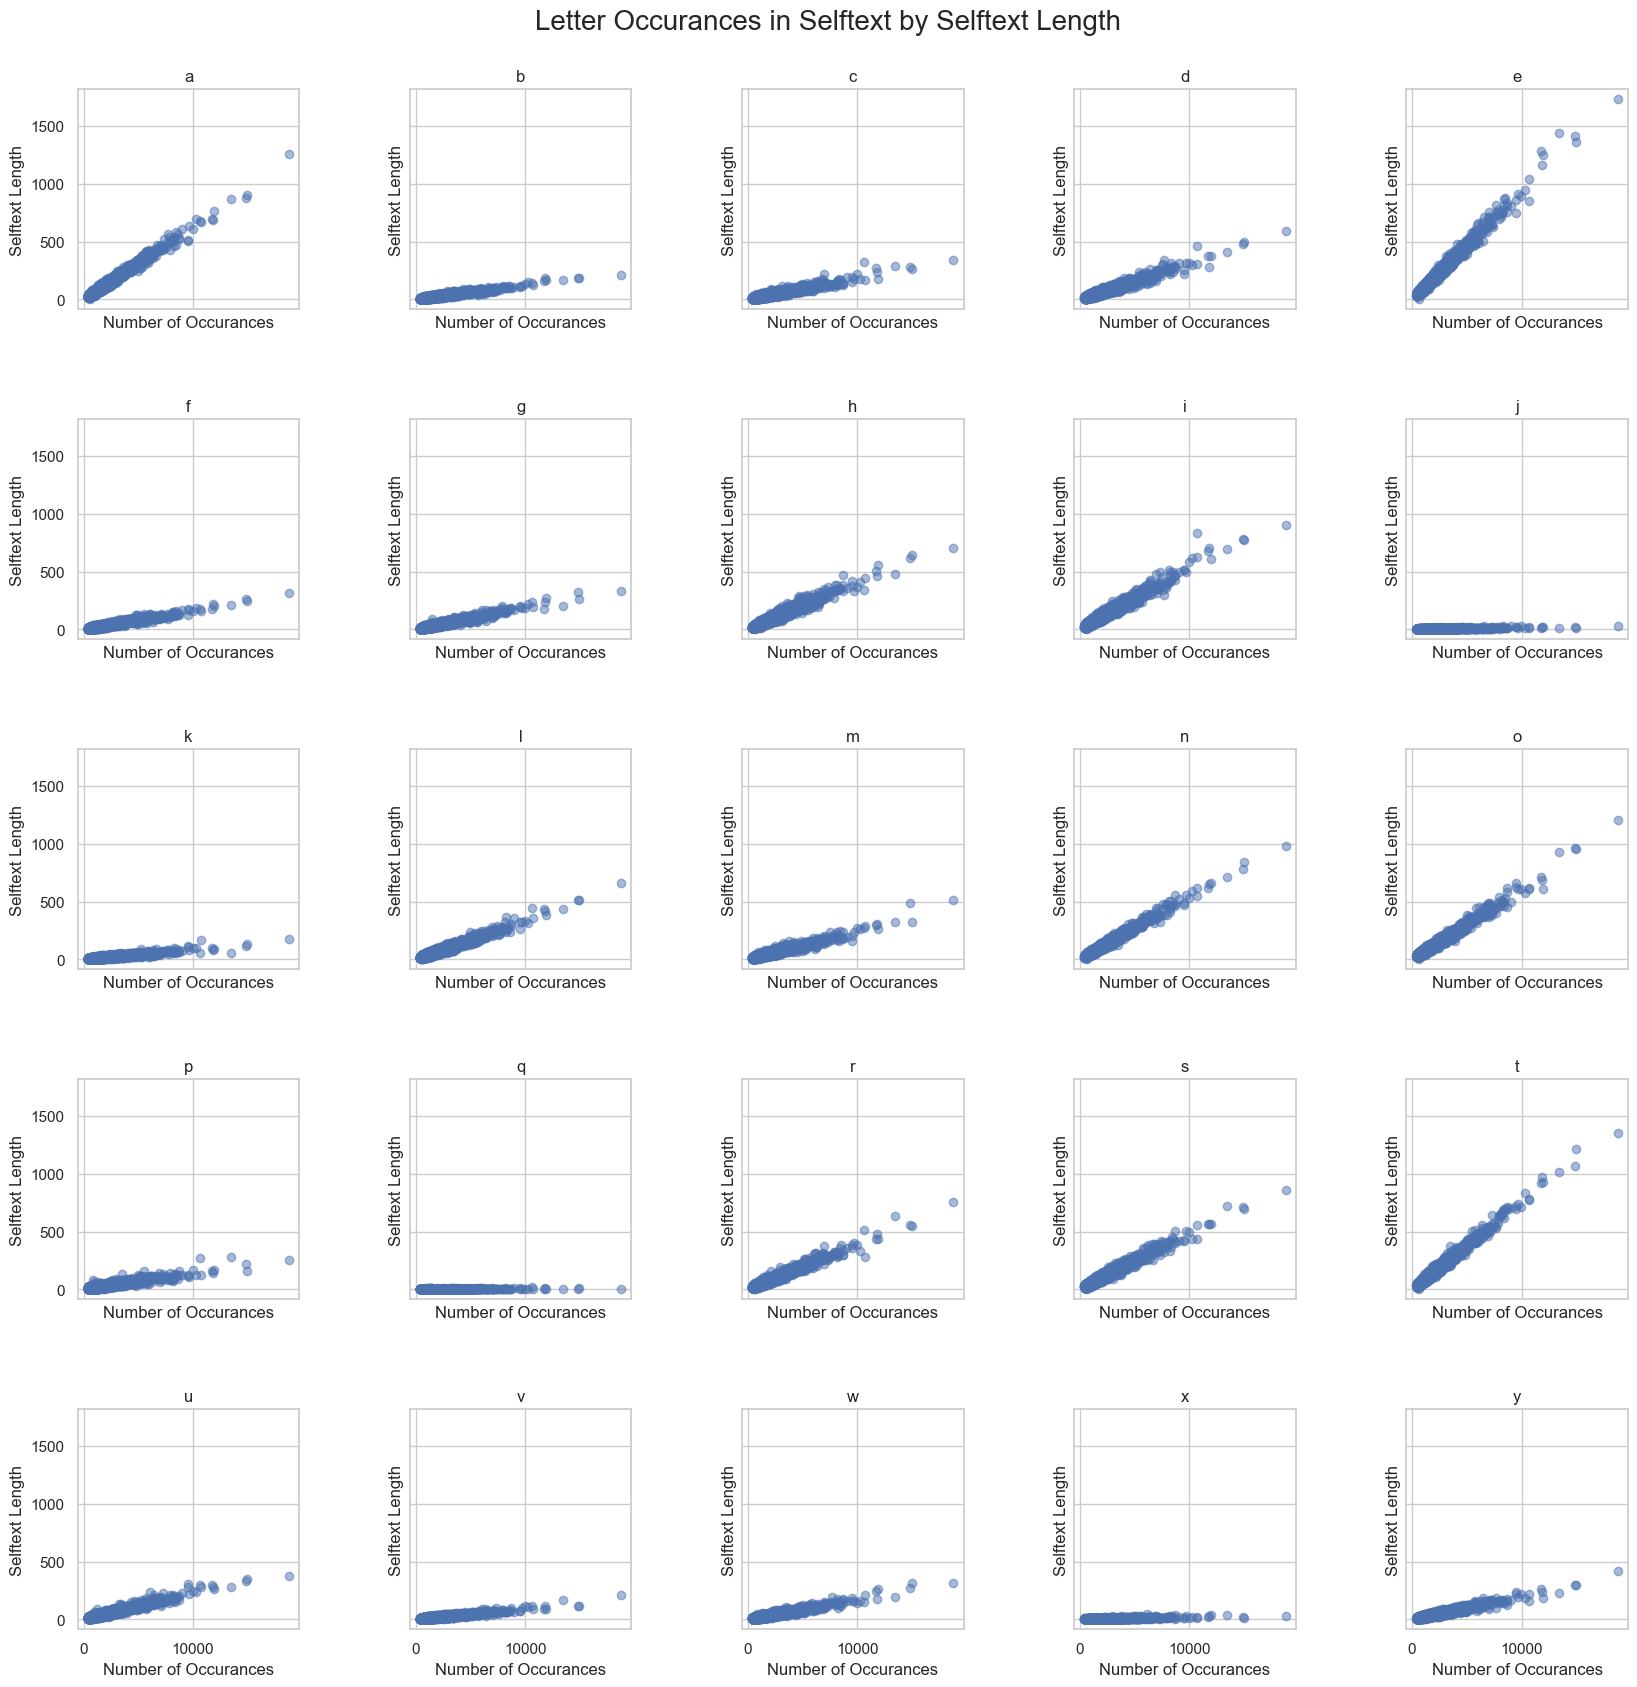

In [73]:
# make a figure plotting letters against number of occurances in selftext for each selftext length bin. To avoid the ValueError "ValueError: num must be 1 <= num <= 16, not 17" the number of bins is set to 25 instead of 26 (the number of letters in the alphabet).
# add a space between the plots to make them easier to read and to make the plot more aesthetically pleasing
# for this code block ignore the IndexError

fig, axes = plt.subplots(5, 5, figsize=(20,20), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# the suptitle should not have so much space between it and the subplots
# the x and y labels should be larger
for i, letter in enumerate('abcdefghijklmnopqrstuvwxyz'):
    try:
        ax = axes[i//5, i%5]
        ax.scatter(df['selftext_length'], df[f'{letter}'], alpha=0.5)
        ax.set_title(letter)
        ax.set_xlabel('Number of Occurances')
        ax.set_ylabel('Selftext Length')
    except IndexError:
        pass
fig.suptitle('Letter Occurances in Selftext by Selftext Length', fontsize=20, y=0.92)
plt.savefig('../images/letter_histograms.png')
plt.show();


In [74]:
# if the data/cleaned_reddit_withsentiment.csv file does not exist, run the following code to create it
# use alivebar
from alive_progress import alive_bar

# if the file already exists, skip this code block and load the file
# if the file exists but the length of the rows is not the same as the length of the rows in the cleaned_reddit.csv file, run the following code to create it
if not os.path.exists('../data/cleaned_reddit_withsentiment.csv') or os.path.getsize('../data/cleaned_reddit_withsentiment.csv') != os.path.getsize('../data/cleaned_reddit.csv'):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    # if the file has a sentiment column, then use that value for each row in the sentiment column (we are just missing some rows)
    # for each row in df, get the sentiment value from the sentiment column and add it to the row in the sentiment column for the new dataframe
    # if the sentiment column does not exist, then use the sentiment value from the sentiment_analysis function
    with alive_bar(len(df)) as bar:
        for i, row in df.iterrows():
            try:
                # load compound, pos, neu, neg values from the sentiment columns in df
                compound = row['sentiment']
                pos = row['positive']
                neu = row['neutral']
                neg = row['negative']
            except KeyError:
                # if the sentiment column does not exist, then use the sentiment value from the sentiment_analysis function
                compound, pos, neu, neg = analyzer.polarity_scores(row['selftext'])['compound'], analyzer.polarity_scores(row['selftext'])['pos'], analyzer.polarity_scores(row['selftext'])['neu'], analyzer.polarity_scores(row['selftext'])['neg']
            # add the sentiment values to the new dataframe
            df.loc[i, 'sentiment'] = compound
            df.loc[i, 'positive'] = pos
            df.loc[i, 'neutral'] = neu
            df.loc[i, 'negative'] = neg
            
            bar()
    # save the data to a csv
    df.to_csv('../data/cleaned_reddit_withsentiment.csv', index=False)
df.head()


|████████████████████████████████████████| 7935/7935 [100%] in 3:05.7 (42.74/s) 


,author,created_utc,id,target,selftext,selftext_length,selftext_word_count,a,b,c,...,u,v,w,x,y,z,sentiment,positive,neutral,negative
0,sh115,1557323366,bm5i03,1,Compulsively reading about things that scare y...,2571,488,177,37,43,...,61,27,30,12,41,2,-0.9832,0.142,0.680,0.178
1,Dazzling_Alight,1581623251,f3fnjt,1,Coronavirus is triggering me so badly I live i...,1045,196,61,11,22,...,28,16,12,1,24,0,-0.9797,0.094,0.718,0.188
2,DH2007able,1560967246,c2kcut,1,I feel like my mind just doesnt want me to be ...,1217,236,67,20,32,...,41,5,17,3,23,0,0.3373,0.076,0.861,0.063
3,sarsapa,1551549663,awkdeg,1,making a mockery out of a mental illness i ope...,1104,227,66,8,22,...,21,12,22,1,20,3,0.5537,0.100,0.805,0.094
4,nealacrea,1563397295,ceisgc,1,How can I better communicate the extent to whi...,974,172,61,7,21,...,19,13,13,4,17,0,0.6365,0.118,0.784,0.097


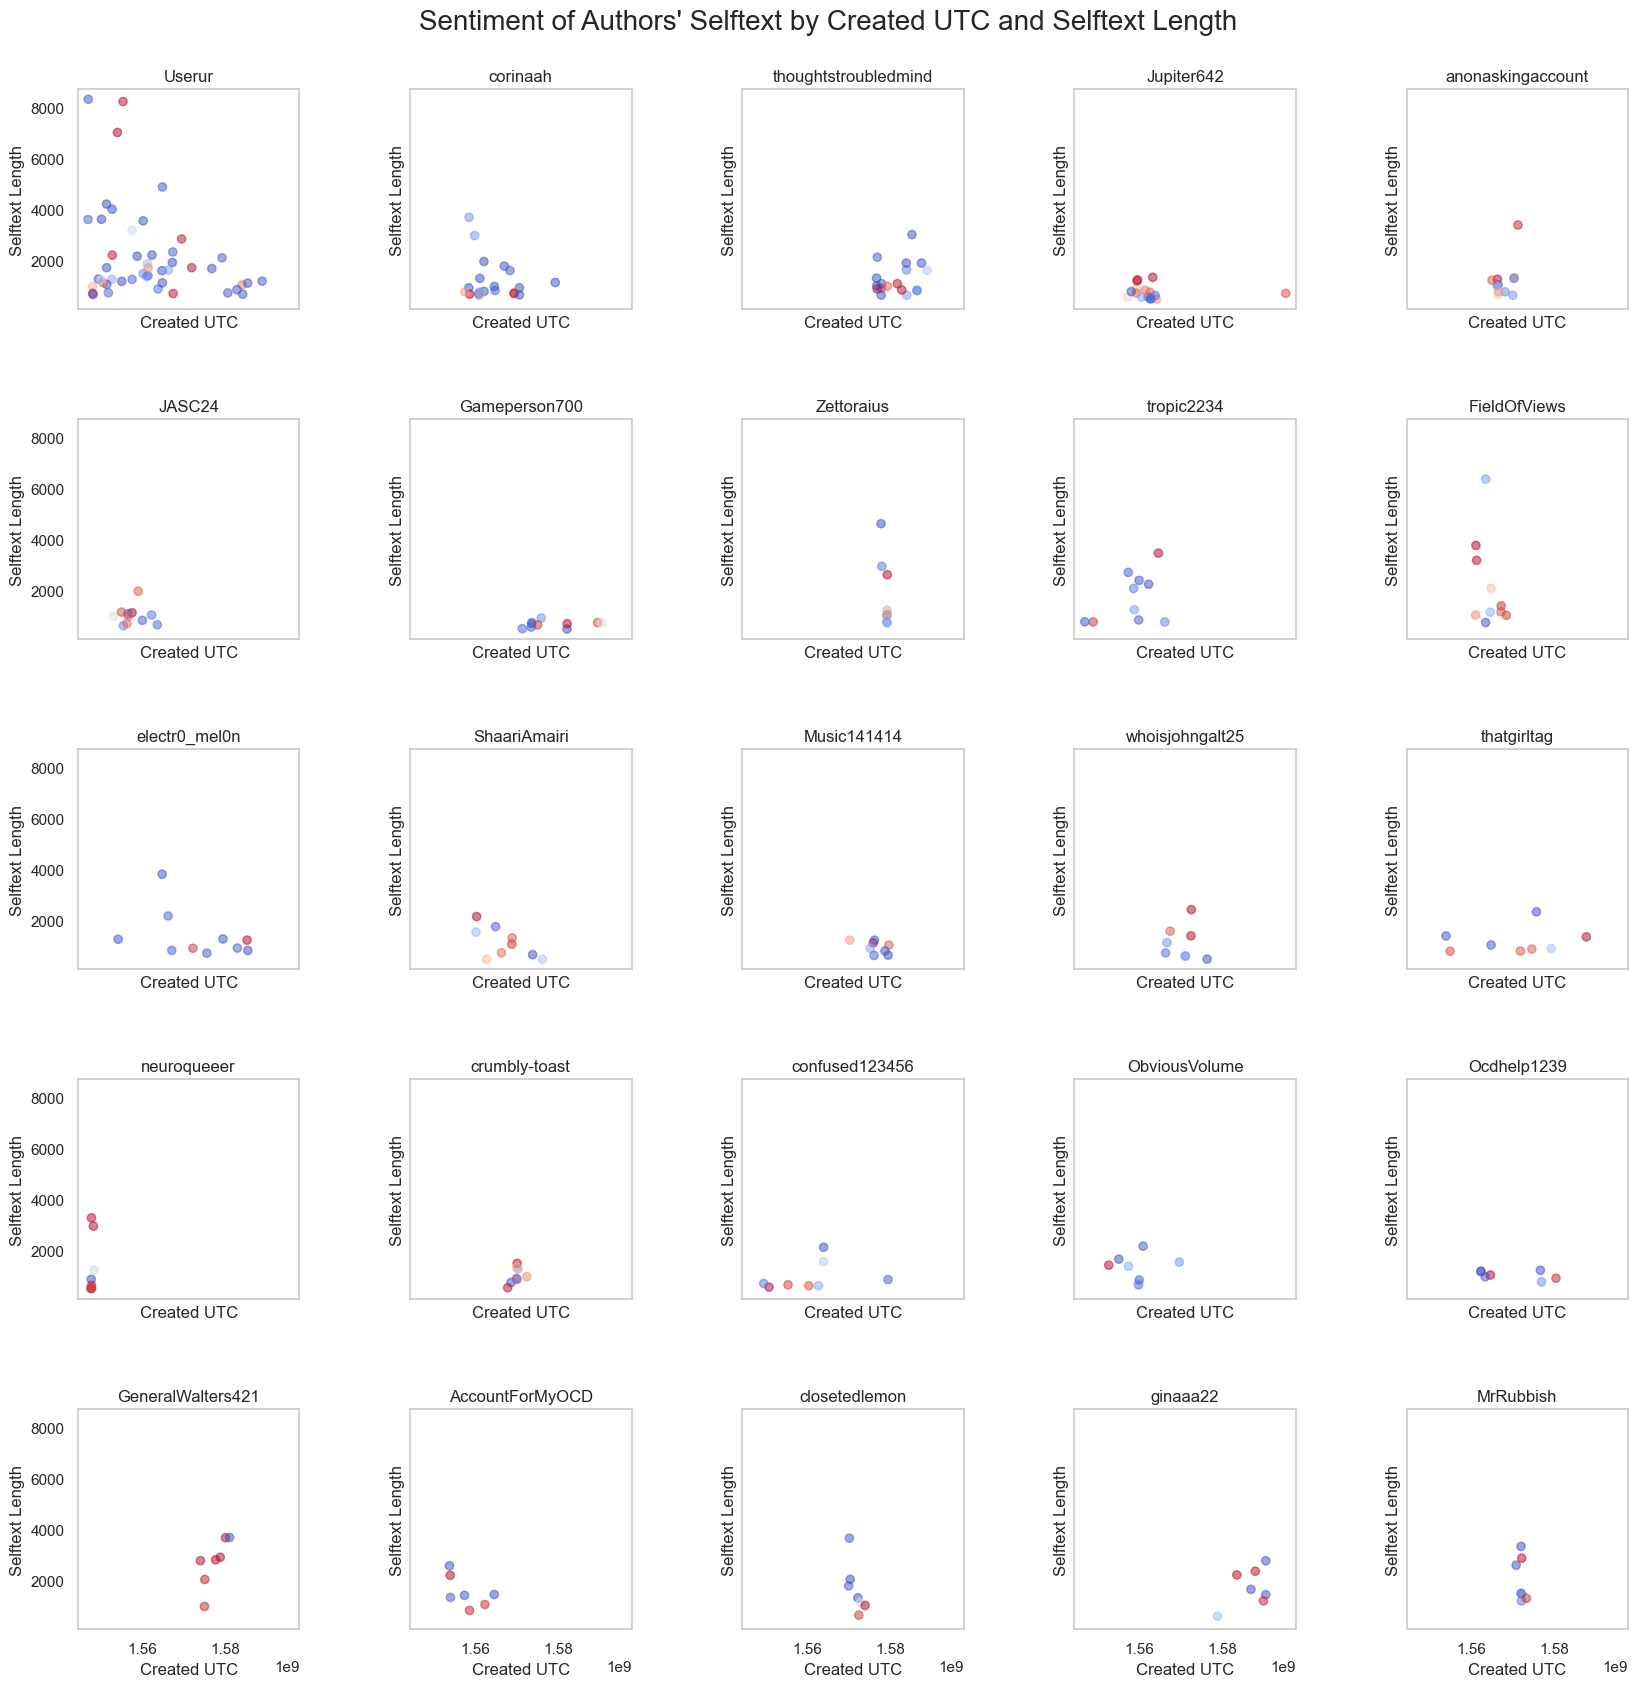

In [75]:
# plot the sentiment values for the top 25 authors (by number of posts) on their own subplots as scatterplots with the x-axis being the created_utc, y-axis being the selftext_length, and color representing the sentiment value column.
# add a space between the plots to make them easier to read and to make the plot more aesthetically pleasing
# for this code block ignore the IndexError
# use coolwarm for the color map to make the colors more distinct

fig, axes = plt.subplots(5, 5, figsize=(20,20), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# the suptitle should not have so much space between it and the subplots
# the x and y labels should be larger
for i, author in enumerate(df['author'].value_counts().index[:25]):
    try:
        ax = axes[i//5, i%5]
        ax.grid(False) # or use plt.grid(b=None) to remove the grid from all subplots
        ax.scatter(df[df['author']==author]['created_utc'], df[df['author']==author]['selftext_length'], c=df[df['author']==author]['sentiment'], cmap='coolwarm', alpha=0.5)
        ax.set_title(author)
        ax.set_xlabel('Created UTC')
        ax.set_ylabel('Selftext Length')
    except IndexError:
        pass
fig.suptitle('Sentiment of Authors\' Selftext by Created UTC and Selftext Length', fontsize=20, y=0.92)
plt.savefig('../images/sentiment_by_author.png')
plt.show();

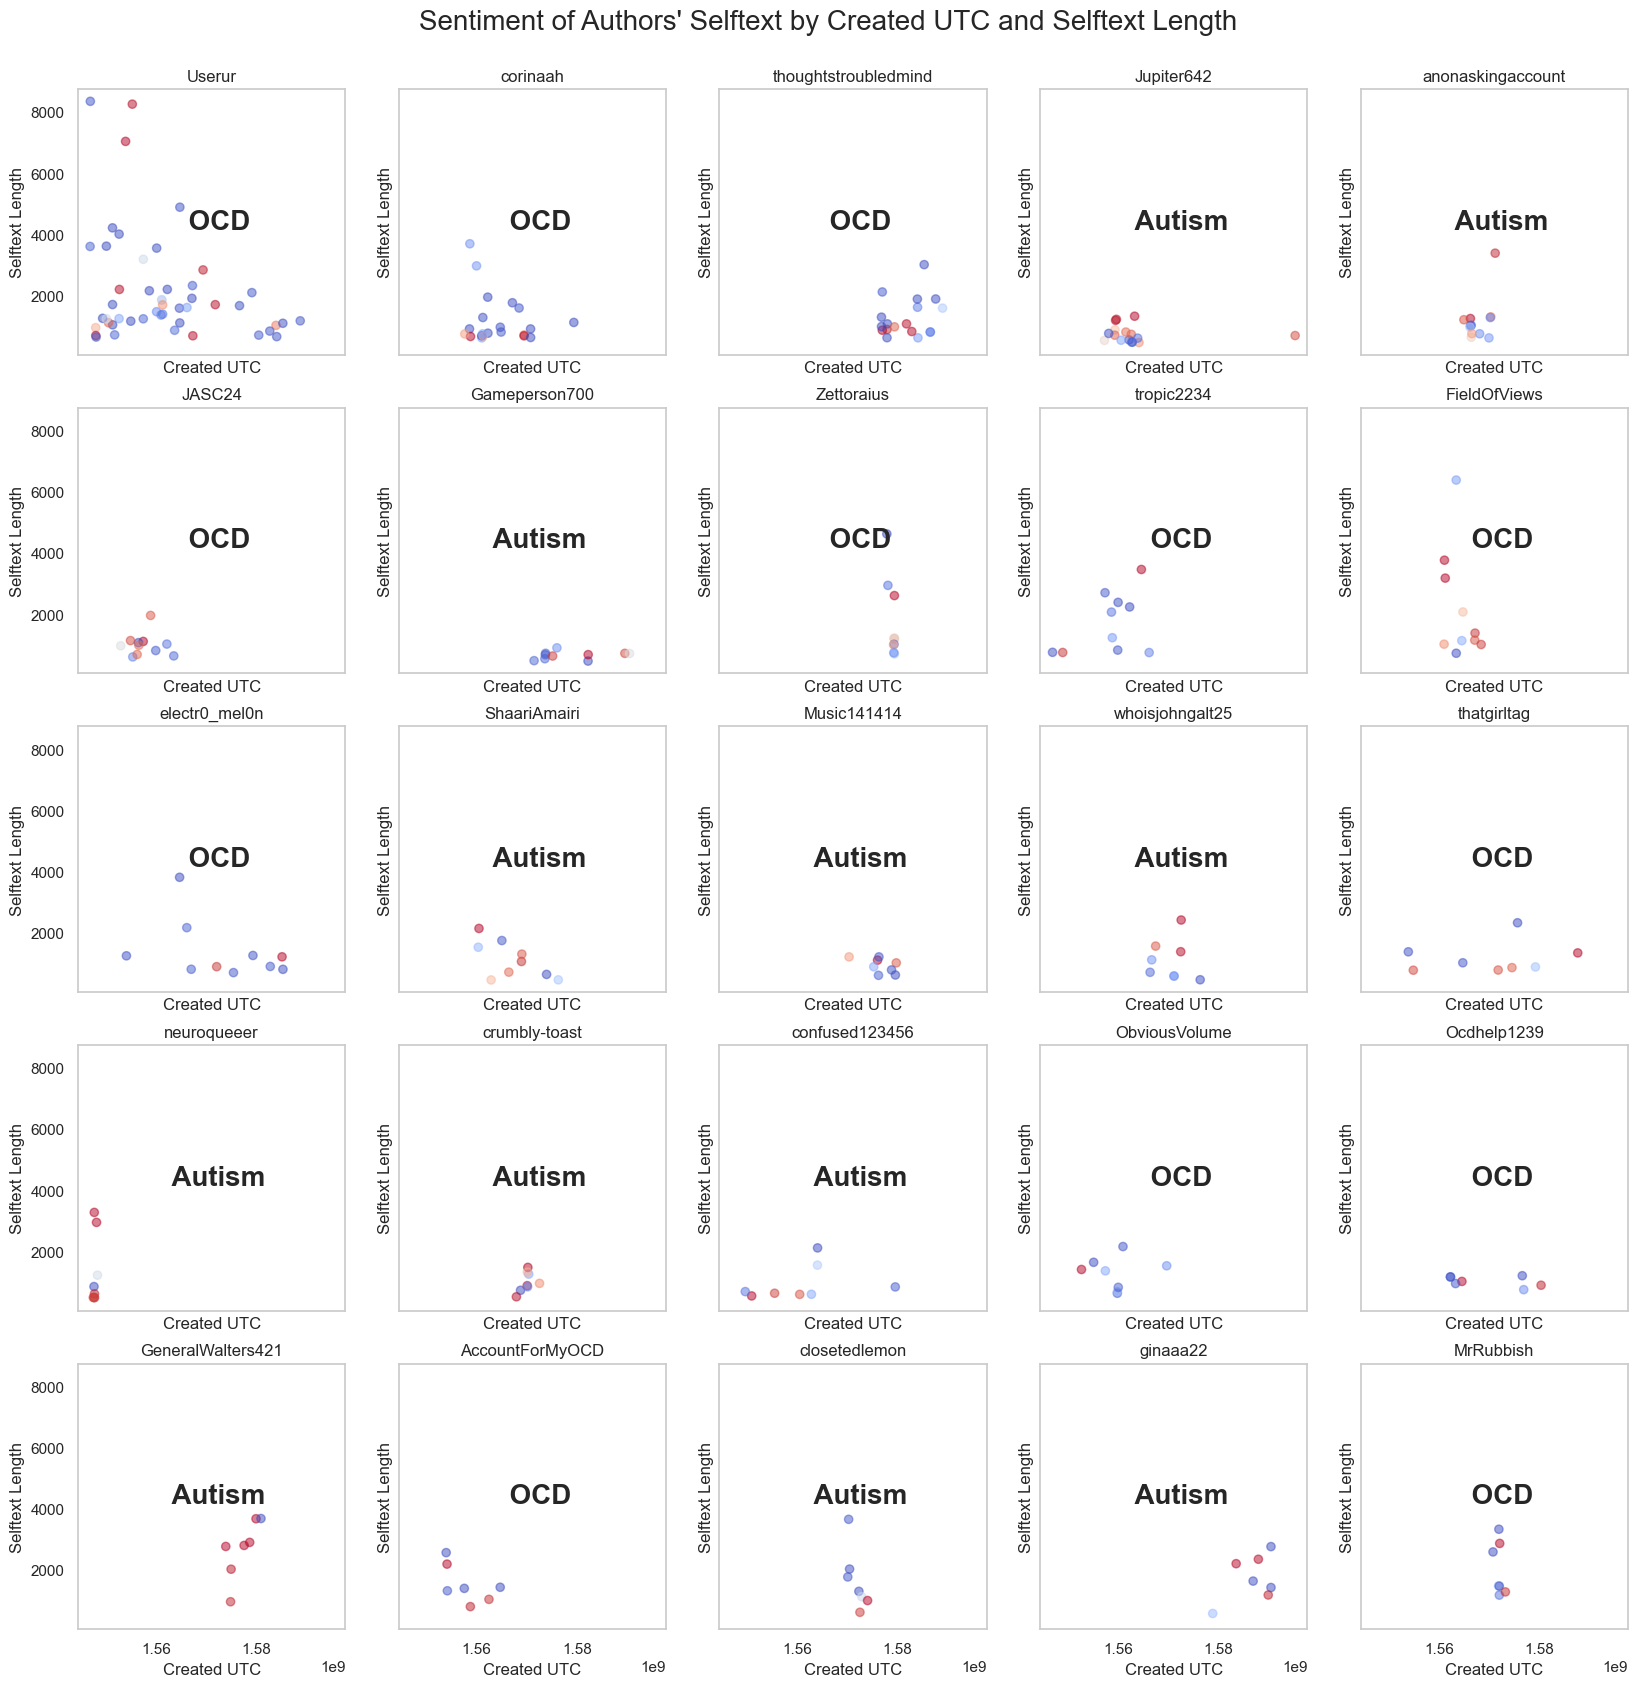

In [76]:
# plot the sentiment values for the top 25 authors (by number of posts) on their own subplots as scatterplots with the x-axis being the created_utc, y-axis being the selftext_length, and color representing the sentiment value column.
# add a space between the plots to make them easier to read and to make the plot more aesthetically pleasing
# for this code block ignore the IndexError
# use coolwarm for the color map to make the colors more distinct
# add an annotation to each plot that shows the target value for that author (0 or 1) but for 1 show the text 'OCD' and for 0 show the text 'Autism' (this is the target column in the df) and make the text larger and bold.

fig, axes = plt.subplots(5, 5, figsize=(20,20), sharey=True, sharex=True)
# fig.subplots_adjust(hspace=0.5, wspace=0.5)
# the suptitle should not have so much space between it and the subplots
# the x and y labels should be larger
for i, author in enumerate(df['author'].value_counts().index[:25]):
    try:
        ax = axes[i//5, i%5]
        ax.scatter(df[df['author']==author]['created_utc'], df[df['author']==author]['selftext_length'], c=df[df['author']==author]['sentiment'], cmap='coolwarm', alpha=0.5)
        ax.set_title(author)
        ax.grid(False) # or use plt.grid(b=None) to remove the grid from all subplots
        ax.set_xlabel('Created UTC')
        ax.set_ylabel('Selftext Length')
        if df[df['author']==author]['target'].values[0] == 1:
            ax.text(0.5, 0.5, '  OCD', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20, fontweight='bold')
        else:
            ax.text(0.5, 0.5, '  Autism', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20, fontweight='bold')
    except IndexError:
        pass
fig.suptitle('Sentiment of Authors\' Selftext by Created UTC and Selftext Length', fontsize=20, y=0.92)
plt.savefig('../images/sentiment_by_author_with_target.png')
plt.show();

In [83]:
# check the posts that were posted within the UTC range listed above. (1.5475 to 1.598)
# 1547500000 to 1598000000 (UTC)
df = pd.read_csv('../data/cleaned_reddit_withsentiment.csv')
df = df[(df['created_utc'] >= 1547500000) & (df['created_utc'] <= 1598000000)] # filter the dataframe to only include posts that were posted within the UTC range listed above. (1.5475 to 1.598)
df.head()


,author,created_utc,id,target,selftext,selftext_length,selftext_word_count,a,b,c,...,u,v,w,x,y,z,sentiment,positive,neutral,negative
0,sh115,1557323366,bm5i03,1,Compulsively reading about things that scare y...,2571,488,177,37,43,...,61,27,30,12,41,2,-0.9832,0.142,0.680,0.178
1,Dazzling_Alight,1581623251,f3fnjt,1,Coronavirus is triggering me so badly I live i...,1045,196,61,11,22,...,28,16,12,1,24,0,-0.9797,0.094,0.718,0.188
2,DH2007able,1560967246,c2kcut,1,I feel like my mind just doesnt want me to be ...,1217,236,67,20,32,...,41,5,17,3,23,0,0.3373,0.076,0.861,0.063
3,sarsapa,1551549663,awkdeg,1,making a mockery out of a mental illness i ope...,1104,227,66,8,22,...,21,12,22,1,20,3,0.5537,0.100,0.805,0.094
4,nealacrea,1563397295,ceisgc,1,How can I better communicate the extent to whi...,974,172,61,7,21,...,19,13,13,4,17,0,0.6365,0.118,0.784,0.097


In [84]:
# add 'ocd_selftext_length' and 'autism_selftext_length' columns to the df
df['selftext_length'] = df['selftext'].apply(lambda x: len(x))
df['ocd_selftext_length'] = df[df['target']==1]['selftext_length']
df['autism_selftext_length'] = df[df['target']==0]['selftext_length']
df['posts_by_author'] = df['author'].map(df['author'].value_counts()) # add a column to the df that shows the number of posts by each author


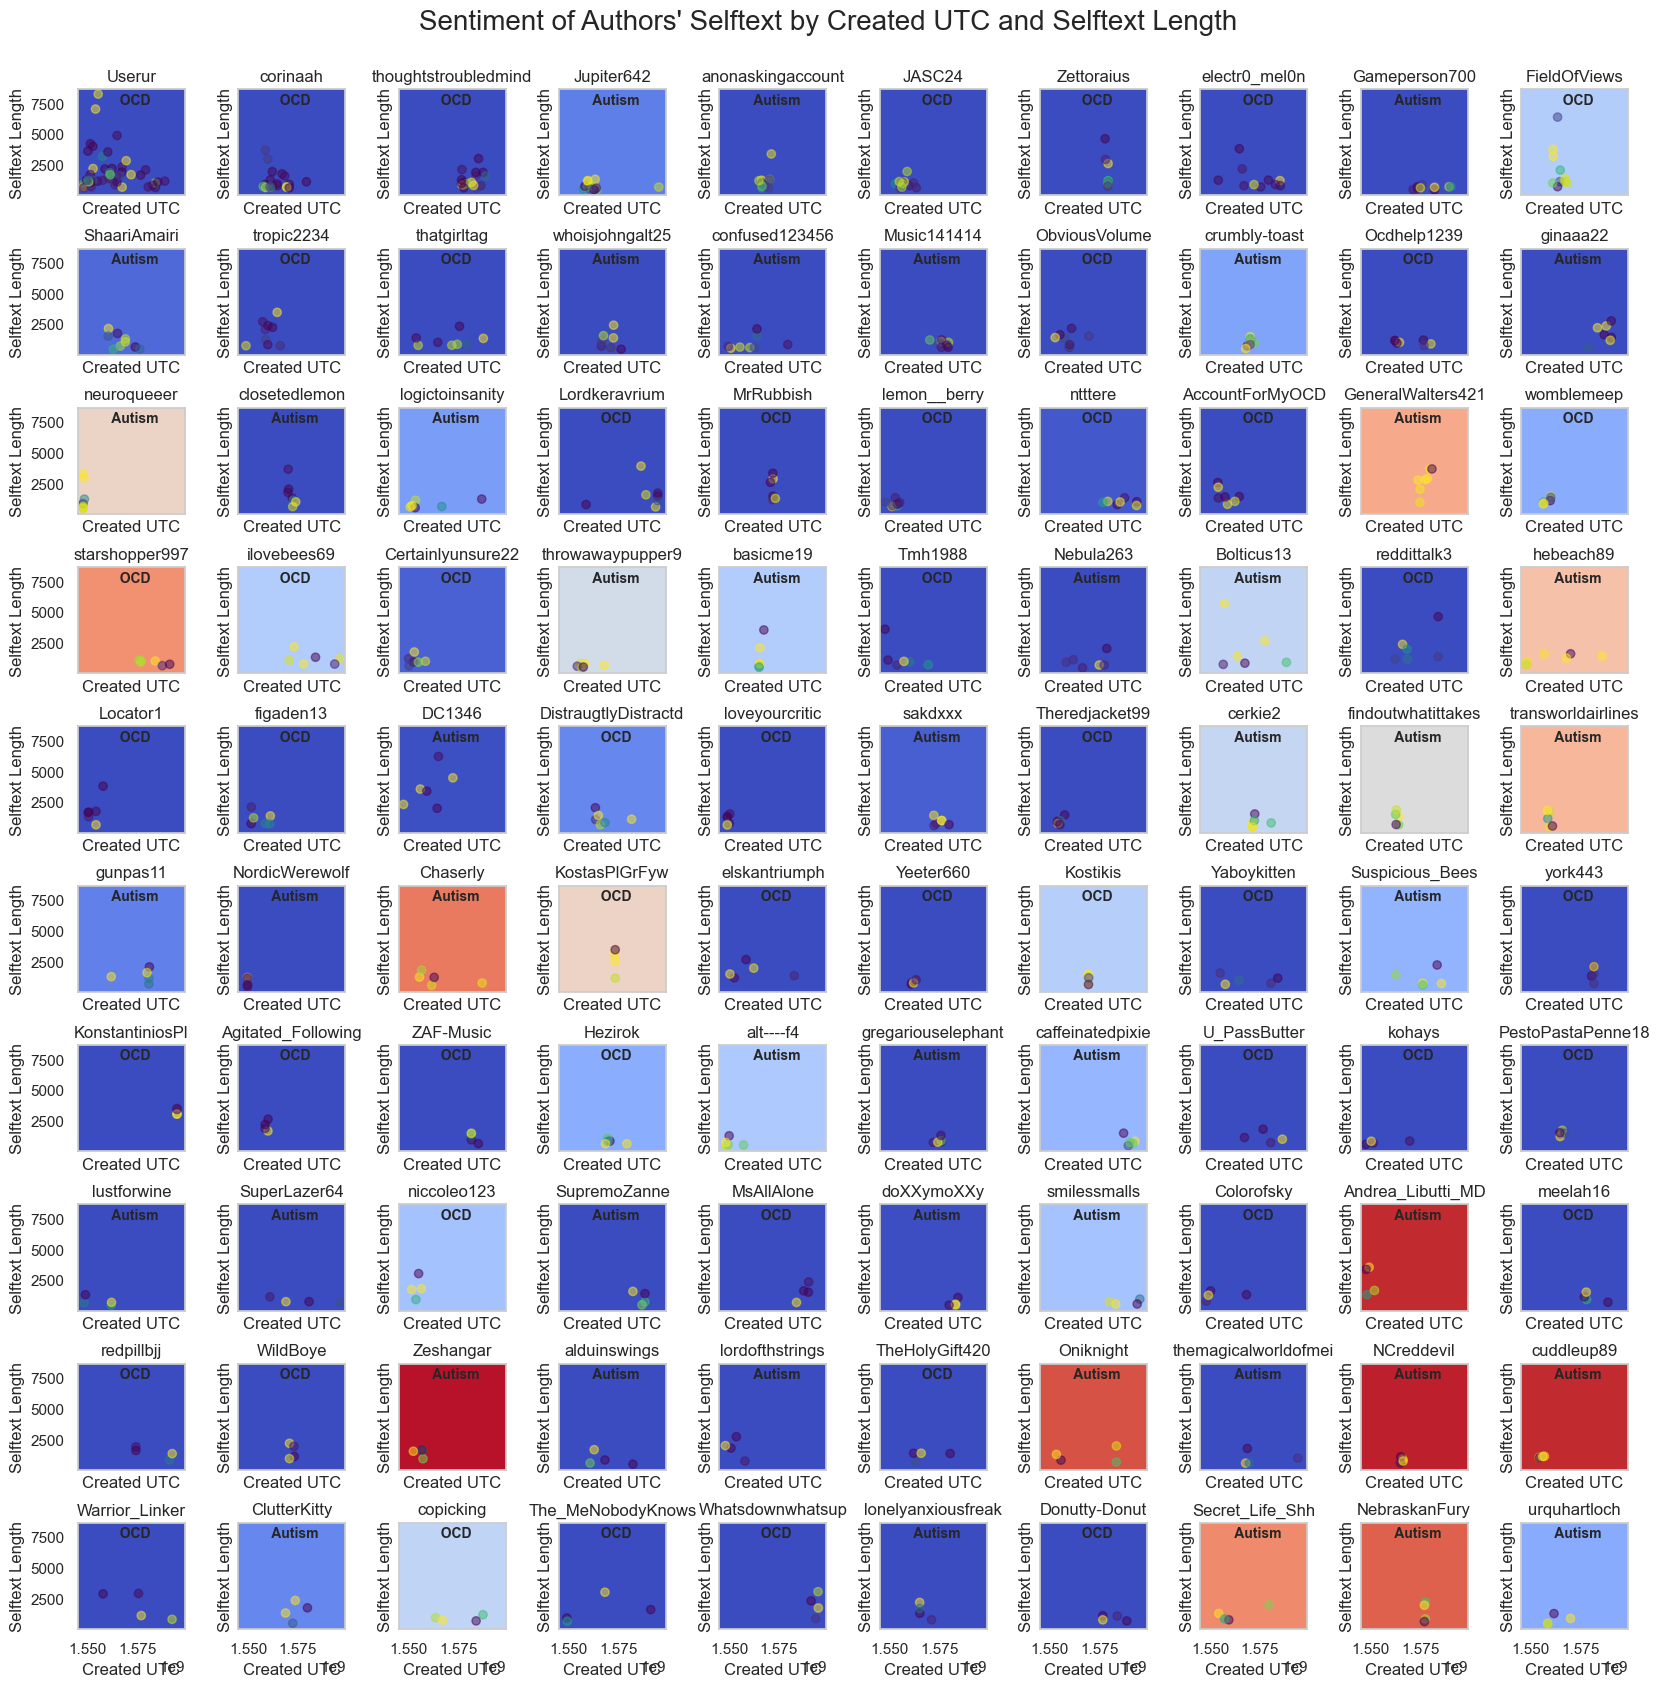

In [85]:
# plot the sentiment values for the top 100 authors (by number of posts) on their own subplots as scatterplots with the x-axis being the created_utc, y-axis being the selftext_length, and color representing the sentiment value column.
# add a space between the plots to make them easier to read and to make the plot more aesthetically pleasing
# for this code block ignore the IndexError
# use coolwarm for the color map to make the colors more distinct
# add an annotation to each plot that shows the target value for that author (0 or 1) but for 1 show the text 'OCD' and for 0 show the text 'Autism' (this is the target column in the df) and make the text larger and bold.
# make the background color of each plot correspond to the average sentiment value for that author in the `sentiment` column (this is the average sentiment value for all of the posts by that author) use the following color map: 'coolwarm' (this is the same color map used for the scatterplots)
# make the background color of the plot lighter if the average sentiment value is closer to 0 and darker if the average sentiment value is closer to 1

fig, axes = plt.subplots(10, 10, figsize=(20,20), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# the suptitle should not have so much space between it and the subplots
# the x and y labels should be larger
for i, author in enumerate(df['author'].value_counts().index[:100]):
    try:
        ax = axes[i//10, i%10]
        ax.scatter(df[df['author']==author]['created_utc'], df[df['author']==author]['selftext_length'], c=df[df['author']==author]['sentiment'], cmap='viridis', alpha=0.5)
        # add a colorbar to the plot and label it 'Sentiment' (this is the sentiment column in the df)
        ax.set_title(author)
        ax.grid(False) # or use plt.grid(b=None) to remove the grid from all subplots
        ax.set_xlabel('Created UTC')
        ax.set_ylabel('Selftext Length')
        if df[df['author']==author]['target'].values[0] == 1:
            # align text horizontally at the center of the plot and vertically at the top of the plot
            ax.text(0.5, 0.9, '  OCD', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10, fontweight='bold')
        else:
            ax.text(0.5, 0.9, '  Autism', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10, fontweight='bold')
        ax.set_facecolor(plt.cm.coolwarm(df[df['author']==author]['sentiment'].mean()))
        # colorbar
        # label
    except IndexError:
        pass
fig.suptitle('Sentiment of Authors\' Selftext by Created UTC and Selftext Length', fontsize=20, y=0.92)
# add a legend
plt.savefig('../images/sentiment_by_author_with_target_100_colored.png')
plt.show();

In [86]:
# plot selftext length vs created UTC on one scatterplot
# color - the author
# size - number of posts by that author (total number of posts in the df)
df['posts_by_author'] = df['author'].map(df['author'].value_counts()) # add a column to the df that shows the number of posts by each author
# give each author a random unique hex color code i.e. '#aabbcc' for the first author, '#ffe111' for the second author, etc. (this will be used for the color of the points on the scatterplot)
# use the following color map: 'coolwarm'
import random # this is used to generate random hex color codes
def random_color():
    return '#%06x' % random.randint(0, 0xFFFFFF) # this will generate a random hex color code
df['author_color'] = df['author'].map({author: random_color() for author in df['author'].unique()}) # add a column to the df that shows the color for each author

# sample
df.head()

,author,created_utc,id,target,selftext,selftext_length,selftext_word_count,a,b,c,...,y,z,sentiment,positive,neutral,negative,ocd_selftext_length,autism_selftext_length,posts_by_author,author_color
0,sh115,1557323366,bm5i03,1,Compulsively reading about things that scare y...,2571,488,177,37,43,...,41,2,-0.9832,0.142,0.680,0.178,2571.0,NaN,1,#2dd908
1,Dazzling_Alight,1581623251,f3fnjt,1,Coronavirus is triggering me so badly I live i...,1045,196,61,11,22,...,24,0,-0.9797,0.094,0.718,0.188,1045.0,NaN,1,#760eed
2,DH2007able,1560967246,c2kcut,1,I feel like my mind just doesnt want me to be ...,1217,236,67,20,32,...,23,0,0.3373,0.076,0.861,0.063,1217.0,NaN,1,#7c6ecc
3,sarsapa,1551549663,awkdeg,1,making a mockery out of a mental illness i ope...,1104,227,66,8,22,...,20,3,0.5537,0.100,0.805,0.094,1104.0,NaN,1,#fecaf3
4,nealacrea,1563397295,ceisgc,1,How can I better communicate the extent to whi...,974,172,61,7,21,...,17,0,0.6365,0.118,0.784,0.097,974.0,NaN,1,#bd5ec1


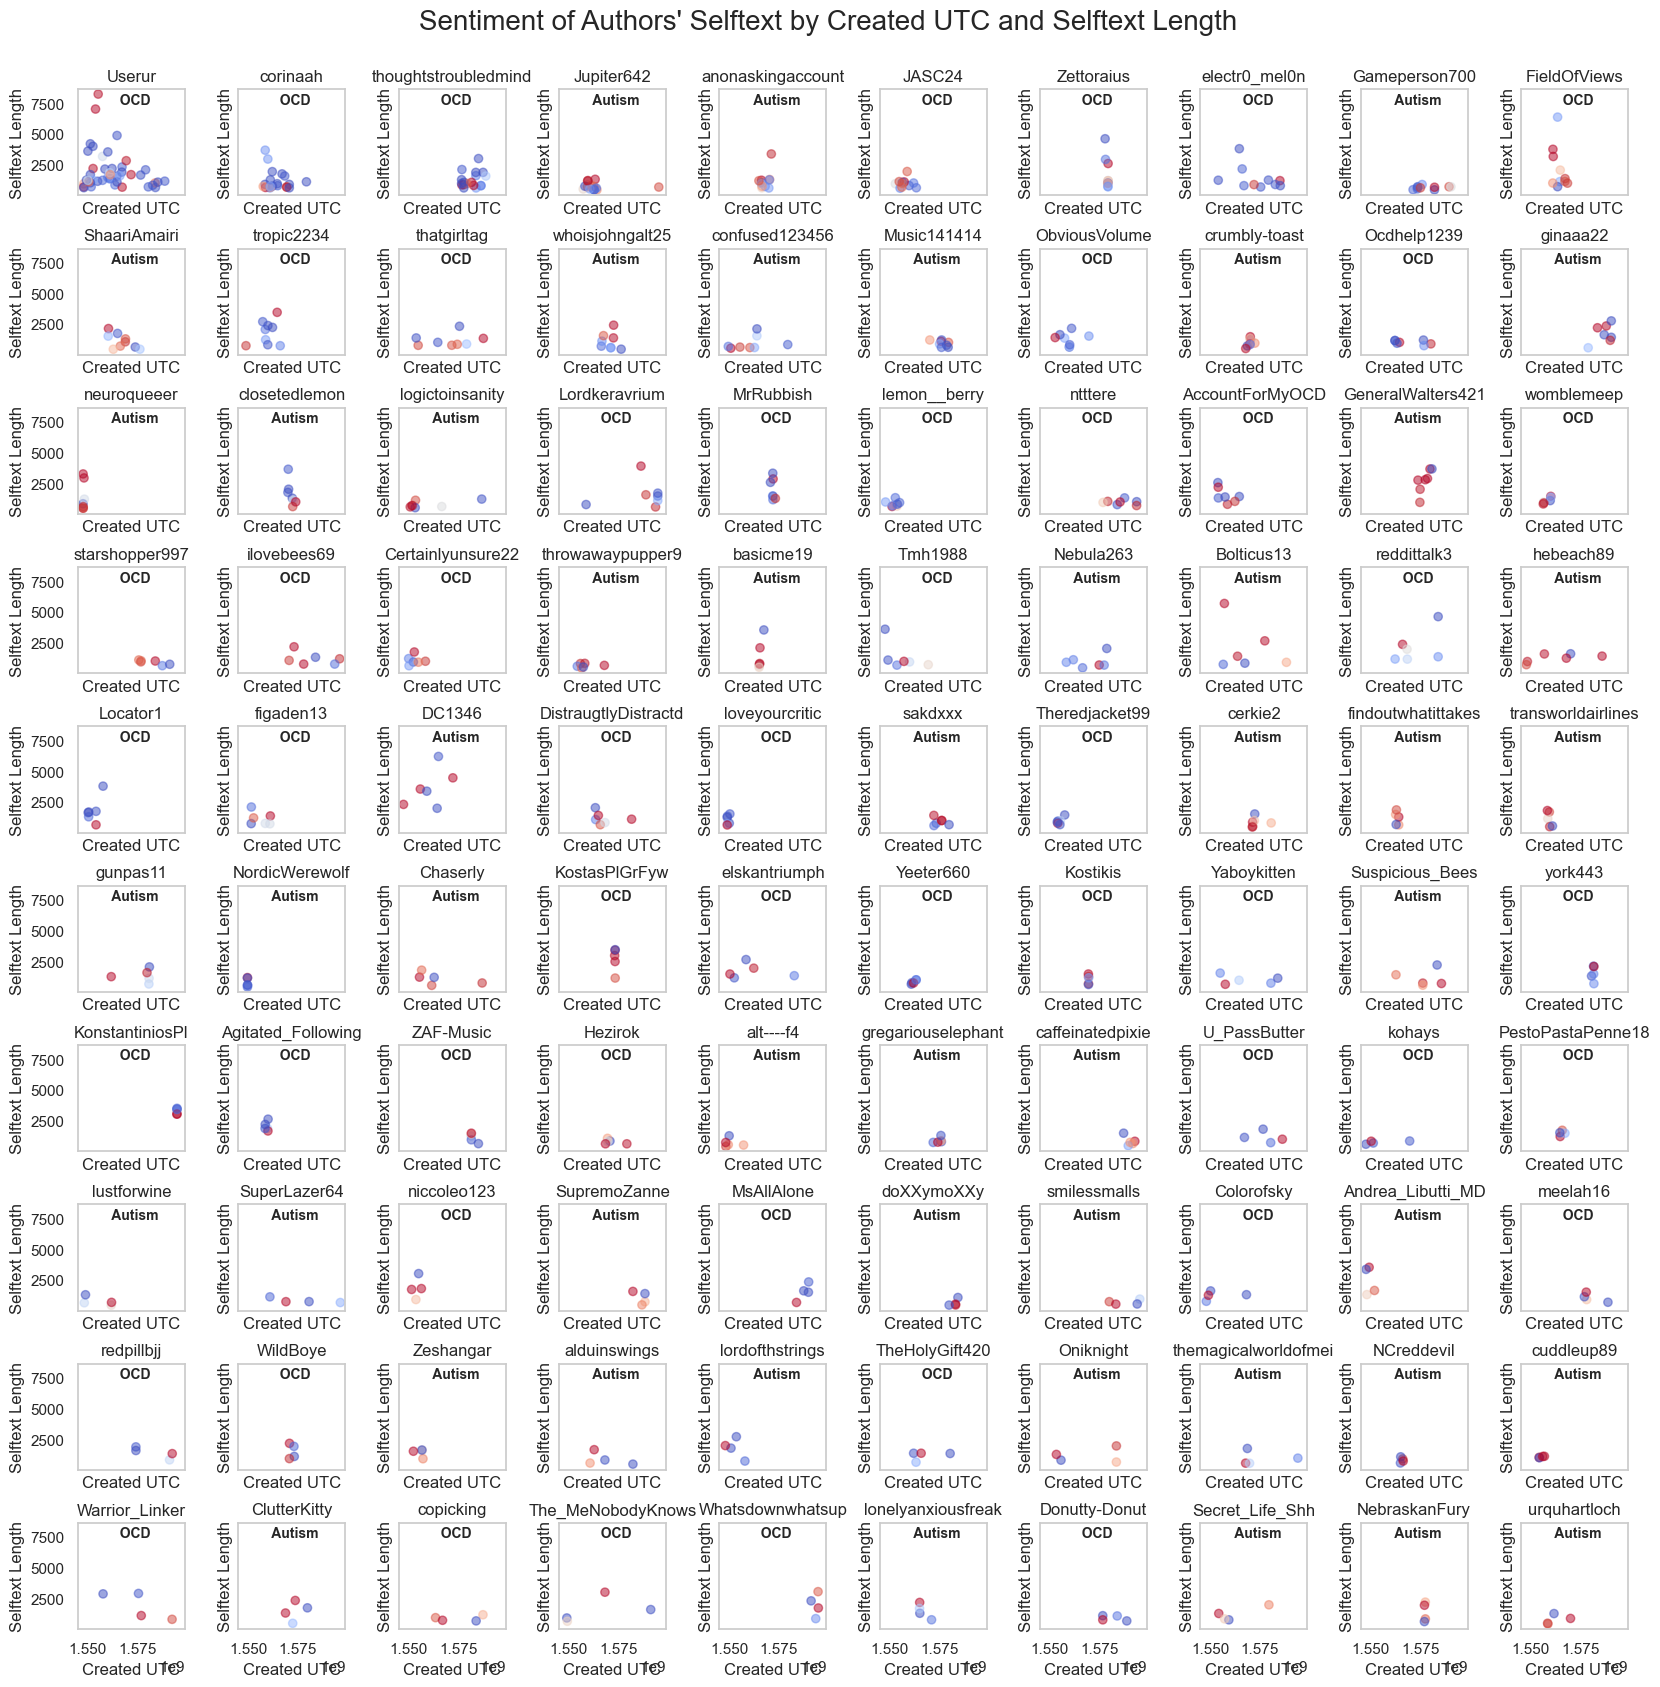

In [87]:
# plot the sentiment values for the top 100 authors (by number of posts) on their own subplots as scatterplots with the x-axis being the created_utc, y-axis being the selftext_length, and color representing the sentiment value column.
# add a space between the plots to make them easier to read and to make the plot more aesthetically pleasing
# for this code block ignore the IndexError
# use coolwarm for the color map to make the colors more distinct
# add an annotation to each plot that shows the target value for that author (0 or 1) but for 1 show the text 'OCD' and for 0 show the text 'Autism' (this is the target column in the df) and make the text larger and bold.

fig, axes = plt.subplots(10, 10, figsize=(20,20), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# the suptitle should not have so much space between it and the subplots
# the x and y labels should be larger
for i, author in enumerate(df['author'].value_counts().index[:100]):
    try:
        ax = axes[i//10, i%10]
        ax.scatter(df[df['author']==author]['created_utc'], df[df['author']==author]['selftext_length'], c=df[df['author']==author]['sentiment'], cmap='coolwarm', alpha=0.5)
        ax.set_title(author)
        ax.grid(False) # or use plt.grid(b=None) to remove the grid from all subplots
        ax.set_xlabel('Created UTC')
        ax.set_ylabel('Selftext Length')
        if df[df['author']==author]['target'].values[0] == 1:
            # align text horizontally at the center of the plot and vertically at the top of the plot
            ax.text(0.5, 0.9, '  OCD', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10, fontweight='bold')
        else:
            ax.text(0.5, 0.9, '  Autism', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10, fontweight='bold')
    except IndexError:
        pass
fig.suptitle('Sentiment of Authors\' Selftext by Created UTC and Selftext Length', fontsize=20, y=0.92)
plt.savefig('../images/sentiment_by_author_with_target_100.png')
plt.show();

In [88]:
IQR = df['selftext_length'].quantile(0.75) - df['selftext_length'].quantile(0.25) # calculate the interquartile range
lower_bound = df['selftext_length'].quantile(0.25) - (1.5 * IQR) # calculate the lower bound
upper_bound = df['selftext_length'].quantile(0.75) + (1.5 * IQR) # calculate the upper bound
print(f'lower bound: {lower_bound} characters in selftext')
print(f'upper bound: {upper_bound} characters in selftext')

# remove outliers from the df
print(f'number of rows in df before removing outliers: {df.shape[0]}')
preshape = df.shape[0]
df = df[(df['selftext_length'] > lower_bound) & (df['selftext_length'] < upper_bound)]
print(f'number of rows in df after removing outliers: {df.shape[0]}')
print(f'number of rows removed: {preshape - df.shape[0]}')
outliers_removed = preshape - df.shape[0]


lower bound: -492.375 characters in selftext
upper bound: 2772.625 characters in selftext
number of rows in df before removing outliers: 7816
number of rows in df after removing outliers: 7250
number of rows removed: 566


/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/3220986543.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['ocd_selftext_length'], shade=True, color='red', alpha=0.5)
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_17791/3220986543.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(df['autism_selftext_length'], shade=True, color='blue', alpha=0.5)


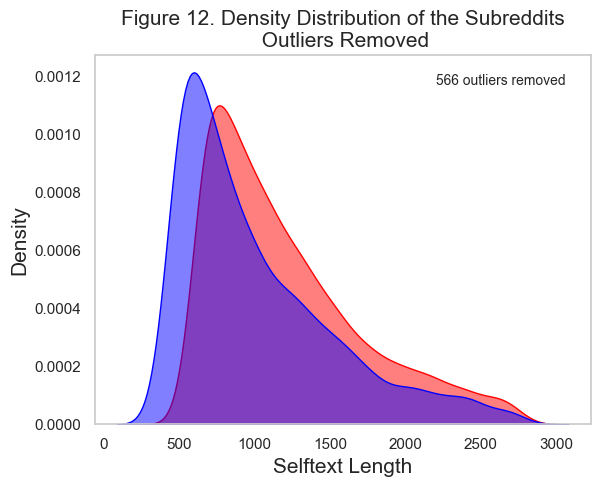

In [89]:
# repeat the plot above (using seaborn) but add a density plot to the plot that shows the distribution of selftext length for the OCD and Autism subreddits (together) - orange filled area (use matplotlib) - this will be the background of the plot (i.e. the density plot will be the background of the plot) - make the density plot transparent by 0.5 (i.e. make it 50% transparent) so that the points are more visible - make the density plot have a black outline

import seaborn as sns
sns.set(style="whitegrid")
# set the area of the plot to focus on the data (i.e. remove the whitespace around the data)
# set the background color of the plot to white
# set the style of the plot to whitegrid
# set the size of the plot to 20 inches by 10 inches



fig = sns.kdeplot(df['ocd_selftext_length'], shade=True, color='red', alpha=0.5)
fig = sns.kdeplot(df['autism_selftext_length'], shade=True, color='blue', alpha=0.5)
plt.title('Figure 12. Density Distribution of the Subreddits\n Outliers Removed', fontsize=15)
# annotate with outlier removal information in top right corner
plt.annotate(f'{outliers_removed} outliers removed', xy=(0.95, 0.95), xycoords='axes fraction', horizontalalignment='right', verticalalignment='top', fontsize=10)
plt.xlabel('Selftext Length', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.grid(False) # or use plt.grid(b=None) to remove the grid from all subplots
# save the figure
plt.savefig('../images/figure_12.png')
plt.show();





In [93]:
# what is the median & mean value preoutlier removal?
median_val_preoutlier_removal = df['selftext_length'].median()
mean_val_preoutlier_removal = df['selftext_length'].mean()

# How many posts have selftext length greater than the median selftext length for the OCD and Autism subreddits (together)?
long_posts_count = df[df['selftext_length'] > median_val_preoutlier_removal].shape[0]
print(f'number of posts with selftext length greater than the median selftext length for the OCD and Autism subreddits (together): {long_posts_count}')
# what is the length of the shortest post created before 1540000000 UTC ?
shortest_post_length = df[df['created_utc'] < 1540000000]['selftext_length'].min()
print(f'length of the shortest post created before 1540000000 UTC: {shortest_post_length} characters')

# let's removed all posts with length less than 570 characters (i.e. the length of the shortest post created before 1540000000 UTC) and then plot the plot again.
# remove all posts with length less than 570 characters
print(f'number of rows in df before removing posts with length less than 570 characters: {df.shape[0]}')
preshape = df.shape[0]
df = df[df['selftext_length'] > 570]
print(f'number of rows in df after removing posts with length less than 570 characters: {df.shape[0]}')
print(f'number of rows removed: {preshape - df.shape[0]}')
short_posts_removed = preshape - df.shape[0]


# when was the earliest OCD post created?
earliest_ocd_post = df[df['target'] == 1]['created_utc'].min() # 1530000000
print(f'earliest OCD post created: {earliest_ocd_post}')
# when was the earliest Autism post created?
earliest_autism_post = df[df['target'] == 0]['created_utc'].min() # 1530000000
print(f'earliest Autism post created: {earliest_autism_post}')

# when was the latest OCD post created?
latest_ocd_post = df[df['target'] == 1]['created_utc'].max() # 1540000000
print(f'latest OCD post created: {latest_ocd_post}')
# when was the latest Autism post created?
latest_autism_post = df[df['target'] == 0]['created_utc'].max() # 1540000000
print(f'latest Autism post created: {latest_autism_post}')

# # remove posts before 1546777579 and after 1596525852
# print(f'number of rows in df before removing posts before 1546777579 and after 1596525852: {df.shape[0]}')
# preshape = df.shape[0]
# df = df[(df['created_utc'] > 1546777579) & (df['created_utc'] < 1596525852)]
# print(f'number of rows in df after removing posts before 1546777579 and after 1596525852: {df.shape[0]}')
# print(f'number of rows removed: {preshape - df.shape[0]}')
# posts_removed = preshape - df.shape[0]


number of posts with selftext length greater than the median selftext length for the OCD and Autism subreddits (together): 3302
length of the shortest post created before 1540000000 UTC: nan characters
number of rows in df before removing posts with length less than 570 characters: 6606
number of rows in df after removing posts with length less than 570 characters: 6606
number of rows removed: 0
earliest OCD post created: 1547631735
earliest Autism post created: 1547508003
latest OCD post created: 1596230555
latest Autism post created: 1596525852


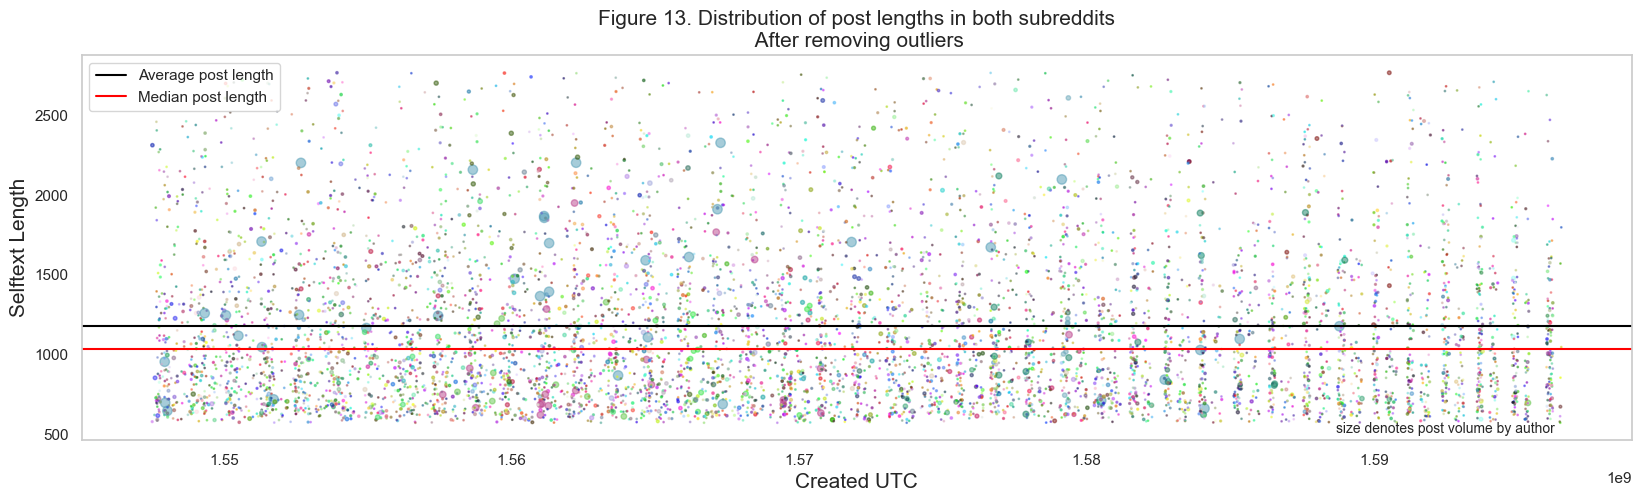

In [94]:
# repeat the plot above but add two horizontal lines to the plot that show:
# 1. the average selftext length for the OCD and Autism subreddits (together) - black line
# 2. the median selftext length for the OCD and Autism subreddits (together) - red line
# also, keep colors the same as before but fade them by 0.5 (i.e. make them 50% transparent) so that the lines are more visible

figure = plt.figure(figsize=(20,5))
plt.scatter(df['created_utc'], df['selftext_length'], c=df['author_color'], s=df['posts_by_author'], alpha=0.5)


plt.title('Figure 13. Distribution of post lengths in both subreddits\n After removing outliers', fontsize=15)
plt.xlabel('Created UTC', fontsize=15)
plt.ylabel('Selftext Length', fontsize=15)
plt.grid(False) # or use plt.grid(b=None) to remove the grid from all subplots
plt.annotate('size denotes post volume by author', xy=(0.95, 0.01), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom', fontsize=10)
plt.axhline(mean_val_preoutlier_removal, color='black', label='Average post length') # using the previously calculated mean value of the selftext length
plt.axhline(median_val_preoutlier_removal, color='red', label='Median post length') # using the previously calculated median value of the selftext length
plt.legend()
plt.savefig('../images/figure_13.png')
plt.show();

In [95]:
# save this version of the dataframe to a csv file in the data folder
df.to_csv('../data/df_outliers_removed.csv', index=False)

# data

* [X_df.csv](./data/X_df.csv) - The features used in the model.
* [autism_thread.csv](./data/autism_thread.csv) - The raw data from the autism thread.
* [best_scores.csv](./data/best_scores.csv) - The best scores from the model.
* [cleaned_reddit.csv](./data/cleaned_reddit.csv) - The cleaned data from the autism thread.
* [cleaned_reddit_withsentiment.csv](./data/cleaned_reddit_withsentiment.csv) - The cleaned data from the autism thread with sentiment analysis. Also includes the OCD thread.
* [cvec.csv](./data/cvec.csv) - The cvec data. Count Vectorized data. This is used in the model.
* [cvec_vocab.txt](./data/cvec_vocab.txt) - The vocabulary used in the cvec data.
* [df_after_feature_engineering.csv](./data/df_after_feature_engineering.csv) - The data after feature engineering. This may not be used in the model.
* [df_cleaned.csv](./data/df_cleaned.csv) - The cleaned data from the autism and OCD threads.
* [drug_info.csv](./data/drug_info.csv) - The drug information from the drugbank database.
* [global_variables.csv](./data/global_variables.csv) - The global variables used in the model.
* [master_results_dataframe.csv](./data/master_results_dataframe.csv) - The master results dataframe.
* [ocd_thread.csv](./data/ocd_thread.csv) - The raw data from the OCD thread.
* [reddit_threads.csv](./data/reddit_threads.csv) - The raw data from the autism and OCD threads.
* [tfidf.csv](./data/tfidf.csv) - The tfidf data. Term Frequency Inverse Document Frequency data. This is used in the model.
* [tfidf_vocab.txt](./data/tfidf_vocab.txt) - The vocabulary used in the tfidf data.
* [y.csv](./data/y.csv) - The target variable used in the model.